# Grouped By Graph Type CNN Model With Contamination Using Heatmaps - Conati Architecture With 3x3 Kernel

In [3]:
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os

In [ ]:
# Common settings
img_height = 288
img_width = 512
batch_size = 32

# Get the project root directory
# Try to find project root by looking for "Heatmaps" folder
current_dir = os.getcwd()
project_root = current_dir

# Navigate up to find project root (where "Heatmaps" exists)
for _ in range(3):  # Check up to 3 levels up
    if os.path.exists(os.path.join(current_dir, "Heatmaps")):
        project_root = current_dir
        break
    parent = os.path.dirname(current_dir)
    if parent == current_dir:  # Reached filesystem root
        break
    current_dir = parent

# Base dataset path: Heatmaps/organized_by_graph_type (at project root)
base_dataset_path = os.path.join(project_root, "Heatmaps", "organized_by_graph_type")

# Print path for verification
print(f"Project root: {project_root}")
print(f"Base dataset path: {base_dataset_path}")

In [5]:

# Function to create a model (based on the paper's CNN architecture, with original input size)
def create_model():
    model = models.Sequential([
        layers.Input(shape=(288, 512, 3)),  # Color images

        layers.Conv2D(16, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(6, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(50, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model


In [ ]:
# Train and evaluate one fold
def train_and_evaluate(dataset_name, fold, average_results):
    dataset_path = os.path.join(base_dataset_path, dataset_name)

    # Load datasets (RGB by default)
    train_ds = image_dataset_from_directory(
        dataset_path,
        validation_split=0.2,
        subset="training",
        seed=42,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        label_mode='binary'
    )

    val_ds = image_dataset_from_directory(
        dataset_path,
        validation_split=0.2,
        subset="validation",
        seed=42,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        label_mode='binary'
    )

    # # Convert RGB to grayscale
    # def convert_to_grayscale(image, label):
    #     image = tf.image.rgb_to_grayscale(image)
    #     return image, label
    #
    # train_ds = train_ds.map(convert_to_grayscale)
    # val_ds = val_ds.map(convert_to_grayscale)

    model = create_model()

    early_stop = EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10,
        callbacks=[early_stop]
    )

    # Plot accuracy
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{dataset_name} - Training vs Validation Accuracy - Fold {fold + 1}')
    plt.legend()
    plt.show()

    # Plot loss
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{dataset_name} - Training vs Validation Loss - Fold {fold + 1}')
    plt.legend()
    plt.show()

    # Evaluate on validation set
    y_true = []
    y_pred = []

    for images, labels in val_ds:
        preds = model.predict(images)
        y_true.extend(labels.numpy().astype(int))
        y_pred.extend((preds > 0.5).astype(int).flatten())

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Illiterate", "Literate"], yticklabels=["Illiterate", "Literate"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{dataset_name} - Confusion Matrix - Fold {fold + 1}')
    plt.show()

    # Track final epoch accuracy
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]

    average_results["train_accuracies"].append(final_train_acc)
    average_results["val_accuracies"].append(final_val_acc)

    print(f"Fold {fold + 1} Final Train Acc: {final_train_acc:.4f}, Final Val Acc: {final_val_acc:.4f}")



=== Running 5-fold CV for: bar ===
Found 779 files belonging to 2 classes.
Using 624 files for training.
Found 779 files belonging to 2 classes.
Using 155 files for validation.
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.5051 - loss: 603.6785 - val_accuracy: 0.5806 - val_loss: 3.6541
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.6120 - loss: 2.7943 - val_accuracy: 0.5097 - val_loss: 1.0510
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.5760 - loss: 0.9385 - val_accuracy: 0.5871 - val_loss: 0.7960
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.7045 - loss: 0.6599 - val_accuracy: 0.5935 - val_loss: 0.6839
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.6384 - loss: 0.7845 - val_accuracy: 0.5871 - val_loss: 0.6906
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.5939 - loss: 0.9740 - val_accuracy: 0.5419 - val_loss: 1.1824
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step 

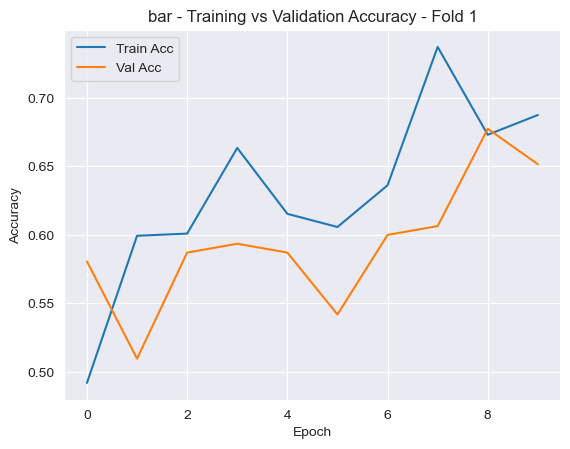

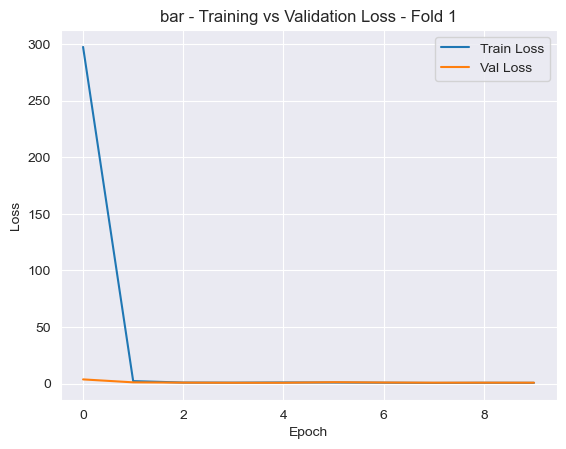

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step


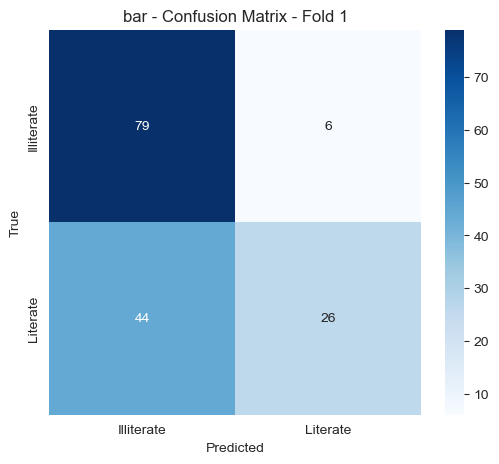

Fold 1 Final Train Acc: 0.6875, Final Val Acc: 0.6516
Found 779 files belonging to 2 classes.
Using 624 files for training.
Found 779 files belonging to 2 classes.
Using 155 files for validation.
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 162ms/step - accuracy: 0.5448 - loss: 148.2083 - val_accuracy: 0.5871 - val_loss: 3.6420
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 0.6089 - loss: 2.8972 - val_accuracy: 0.5871 - val_loss: 1.9370
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.5755 - loss: 1.2743 - val_accuracy: 0.5935 - val_loss: 0.6681
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.6582 - loss: 0.6046 - val_accuracy: 0.6194 - val_loss: 0.6714
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.6518 - loss: 0.6212 - val_accuracy: 0.6774 - val_loss: 0.6029
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.6850 - loss: 0.5649 - val_accuracy: 0.6903 - val_loss: 0.5830
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━

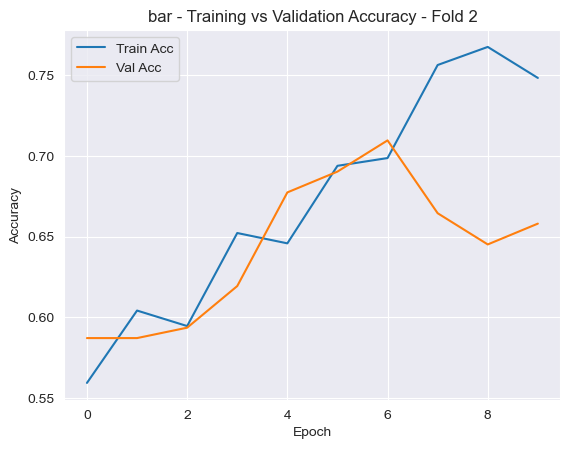

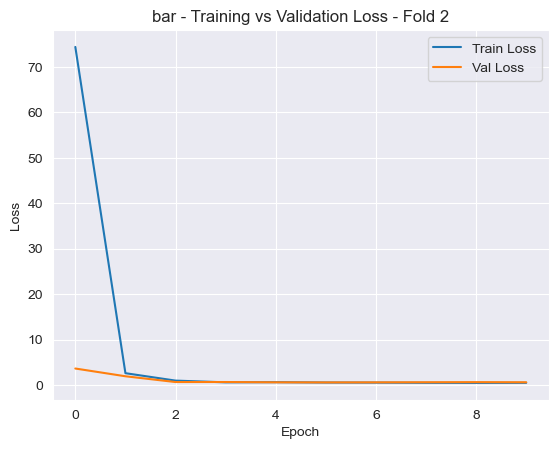

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


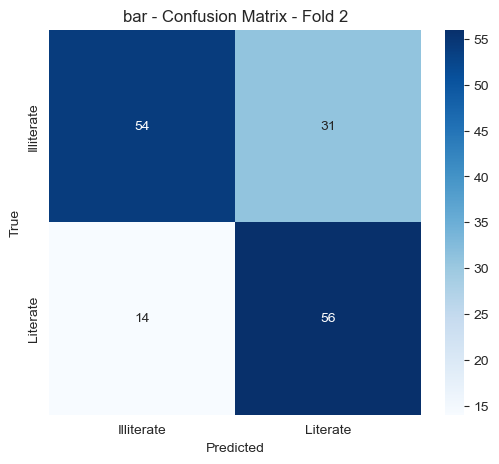

Fold 2 Final Train Acc: 0.7484, Final Val Acc: 0.6581
Found 779 files belonging to 2 classes.
Using 624 files for training.
Found 779 files belonging to 2 classes.
Using 155 files for validation.
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 0.4992 - loss: 242.4577 - val_accuracy: 0.5613 - val_loss: 1.5769
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.5600 - loss: 1.1051 - val_accuracy: 0.5355 - val_loss: 0.6905
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.5650 - loss: 0.6879 - val_accuracy: 0.5032 - val_loss: 0.6937
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.6272 - loss: 0.6917 - val_accuracy: 0.5226 - val_loss: 0.6933


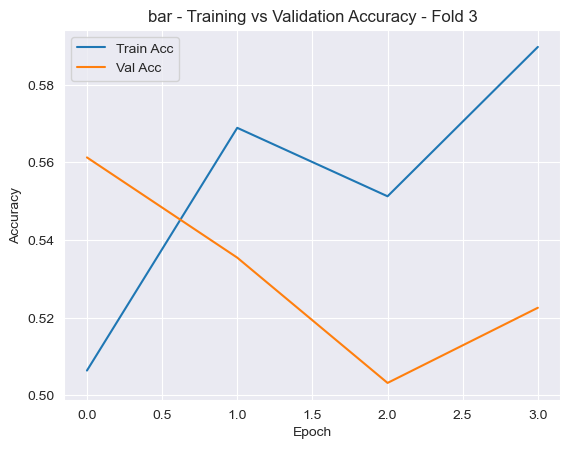

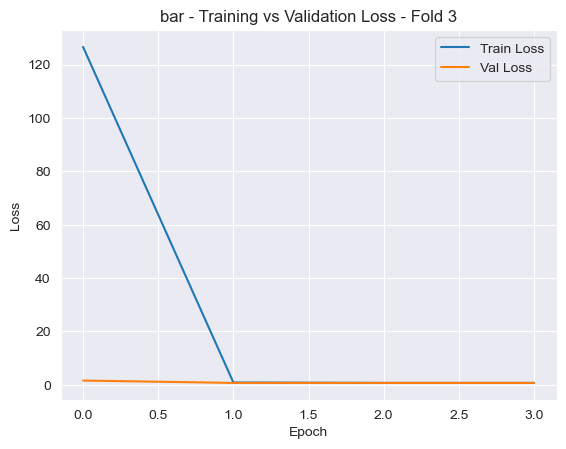

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


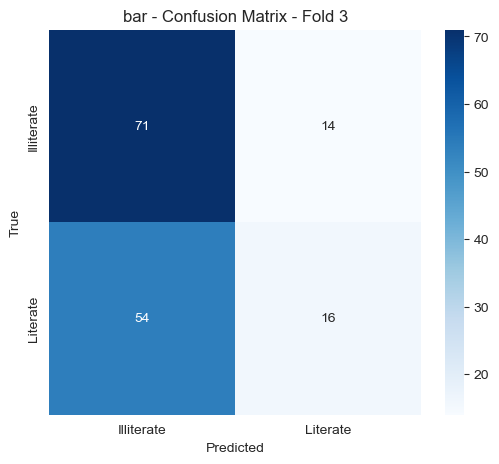

Fold 3 Final Train Acc: 0.5897, Final Val Acc: 0.5226
Found 779 files belonging to 2 classes.
Using 624 files for training.
Found 779 files belonging to 2 classes.
Using 155 files for validation.
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.4727 - loss: 672.1208 - val_accuracy: 0.6129 - val_loss: 7.0855
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.5905 - loss: 11.2059 - val_accuracy: 0.6323 - val_loss: 1.5708
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.5956 - loss: 1.7632 - val_accuracy: 0.5806 - val_loss: 2.8233
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.6723 - loss: 1.6556 - val_accuracy: 0.6065 - val_loss: 1.1799
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.6737 - loss: 0.9657 - val_accuracy: 0.5355 - val_loss: 2.4967


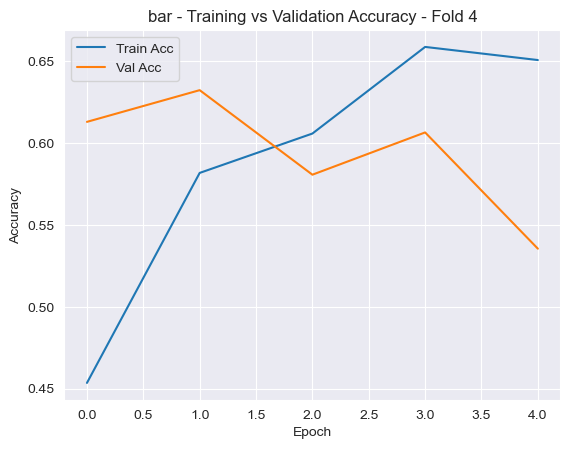

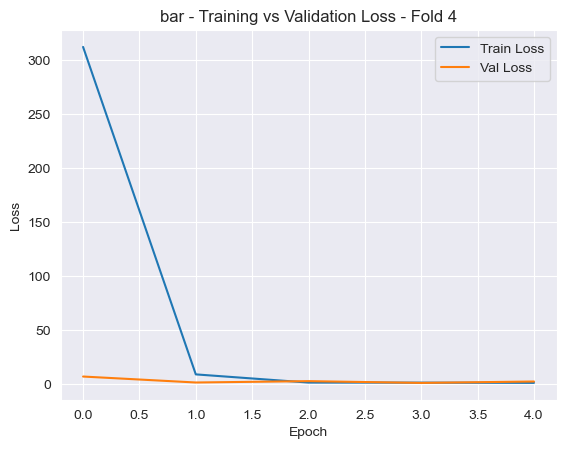

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


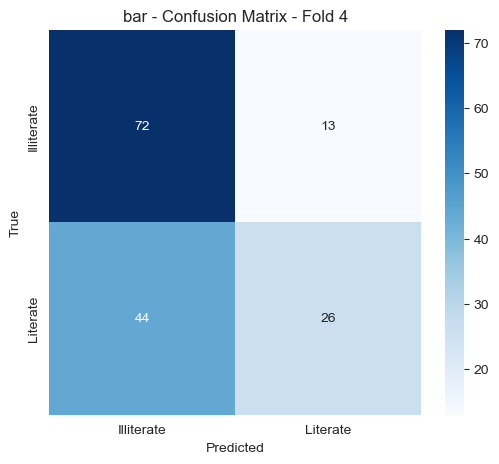

Fold 4 Final Train Acc: 0.6506, Final Val Acc: 0.5355
Found 779 files belonging to 2 classes.
Using 624 files for training.
Found 779 files belonging to 2 classes.
Using 155 files for validation.
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 0.5944 - loss: 60.8654 - val_accuracy: 0.5742 - val_loss: 0.6829
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.6077 - loss: 0.6694 - val_accuracy: 0.6452 - val_loss: 0.6683
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.6746 - loss: 0.6046 - val_accuracy: 0.6323 - val_loss: 0.6868
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.7701 - loss: 0.4927 - val_accuracy: 0.5484 - val_loss: 0.6917
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.5718 - loss: 0.6907 - val_accuracy: 0.5484 - val_loss: 0.6905


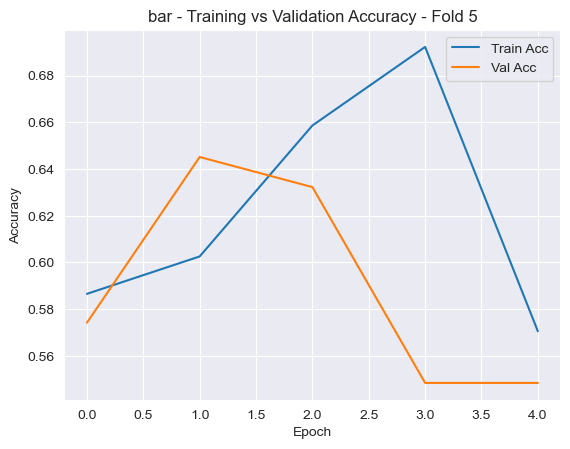

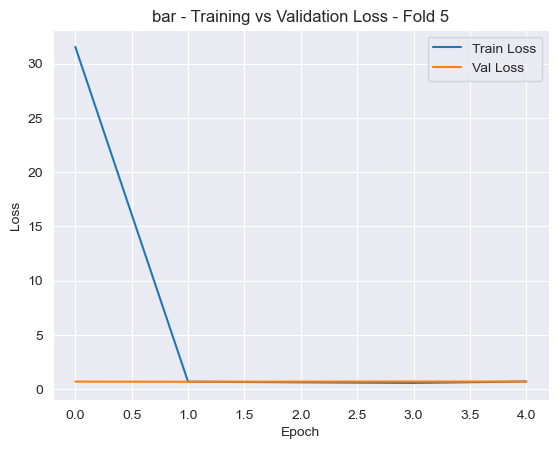

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


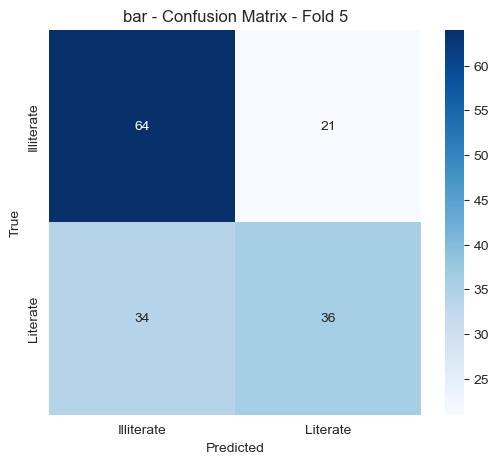

Fold 5 Final Train Acc: 0.5705, Final Val Acc: 0.5484

=== Running 5-fold CV for: line ===
Found 570 files belonging to 2 classes.
Using 456 files for training.
Found 570 files belonging to 2 classes.
Using 114 files for validation.
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 541ms/step - accuracy: 0.4952 - loss: 53.5383 - val_accuracy: 0.5614 - val_loss: 0.6929
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 433ms/step - accuracy: 0.5572 - loss: 0.6929 - val_accuracy: 0.5614 - val_loss: 0.6927
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 439ms/step - accuracy: 0.5483 - loss: 0.6927 - val_accuracy: 0.5614 - val_loss: 0.6924
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 418ms/step - accuracy: 0.5540 - loss: 0.6924 - val_accuracy: 0.5614 - val_loss: 0.6921


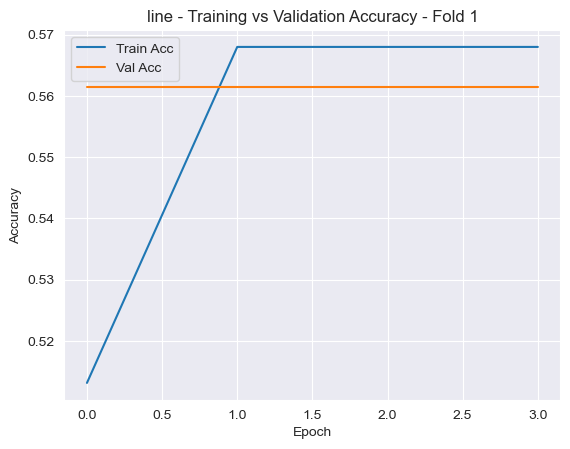

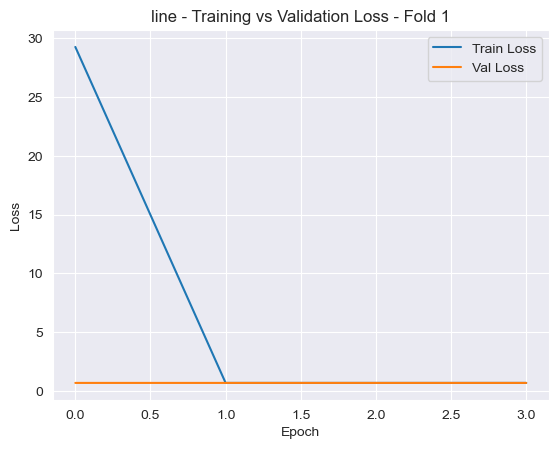

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


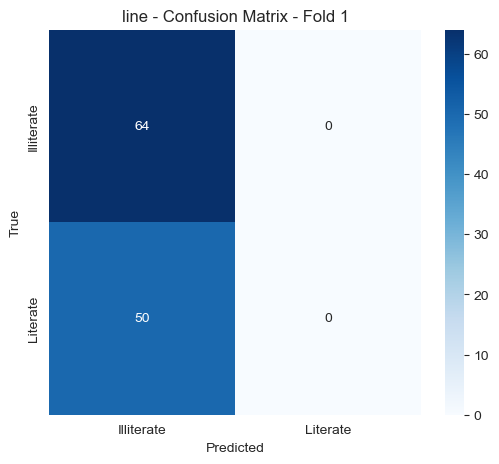

Fold 1 Final Train Acc: 0.5680, Final Val Acc: 0.5614
Found 570 files belonging to 2 classes.
Using 456 files for training.
Found 570 files belonging to 2 classes.
Using 114 files for validation.
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 484ms/step - accuracy: 0.5207 - loss: 317.3805 - val_accuracy: 0.4386 - val_loss: 7.2028
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 429ms/step - accuracy: 0.5298 - loss: 2.8038 - val_accuracy: 0.6053 - val_loss: 0.6230
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 455ms/step - accuracy: 0.6558 - loss: 0.6341 - val_accuracy: 0.6053 - val_loss: 0.6185
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 422ms/step - accuracy: 0.6619 - loss: 0.6047 - val_accuracy: 0.7018 - val_loss: 0.6006
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 456ms/step - accuracy: 0.7095 - loss: 0.5516 - val_accuracy: 0.6491 - val_loss: 0.6252
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 452ms/step - accuracy: 0.7222 - loss: 0.4984 - val_accuracy: 0.6228 - val_loss: 0.6284
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━

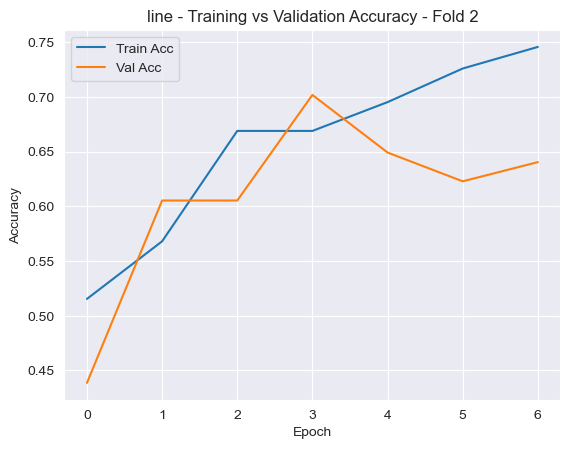

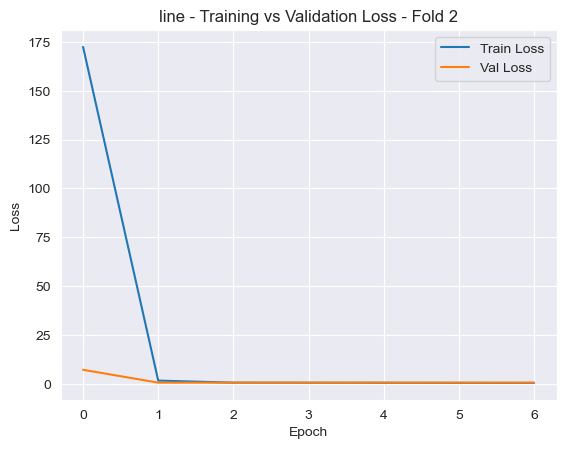

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


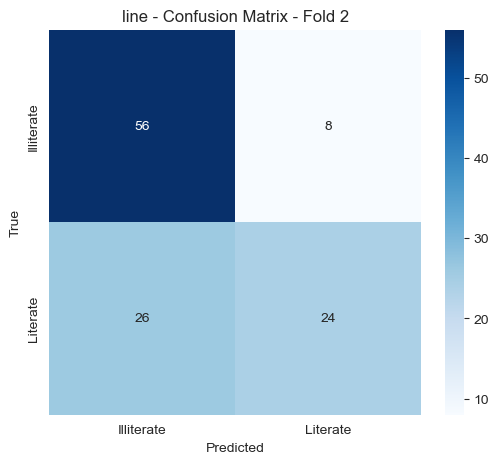

Fold 2 Final Train Acc: 0.7456, Final Val Acc: 0.6404
Found 570 files belonging to 2 classes.
Using 456 files for training.
Found 570 files belonging to 2 classes.
Using 114 files for validation.
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 509ms/step - accuracy: 0.5068 - loss: 644.4465 - val_accuracy: 0.5877 - val_loss: 4.9900
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 465ms/step - accuracy: 0.4731 - loss: 21.2887 - val_accuracy: 0.5614 - val_loss: 3.4350
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 485ms/step - accuracy: 0.5293 - loss: 6.2717 - val_accuracy: 0.5702 - val_loss: 2.9879
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 446ms/step - accuracy: 0.6448 - loss: 1.9386 - val_accuracy: 0.6667 - val_loss: 0.9379
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 453ms/step - accuracy: 0.7161 - loss: 0.6273 - val_accuracy: 0.6667 - val_loss: 0.6691
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 425ms/step - accuracy: 0.7523 - loss: 0.5081 - val_accuracy: 0.6667 - val_loss: 0.6545
Epoch 7/10
15/15 ━━━━━━━━━━━━━━

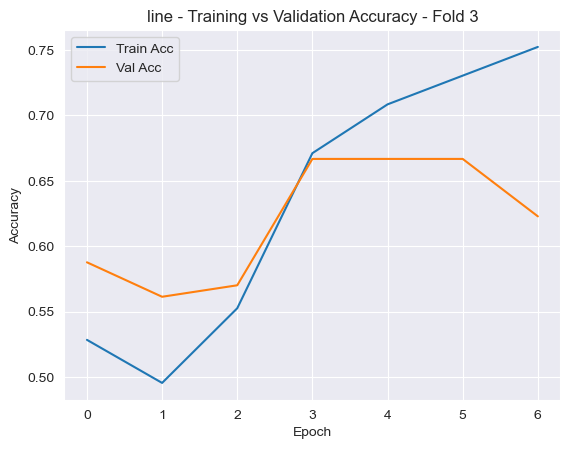

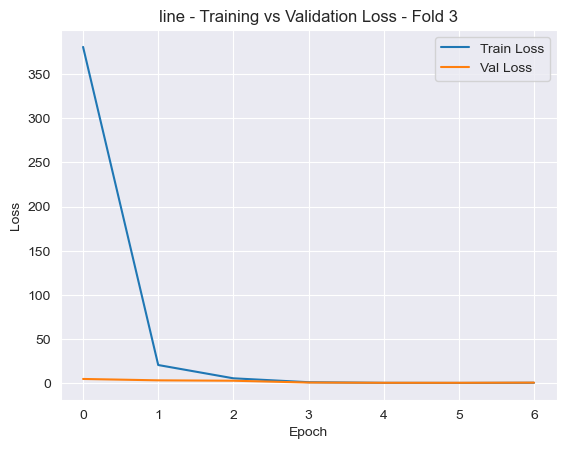

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


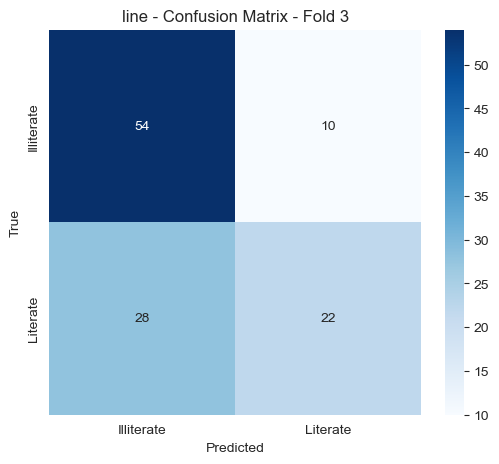

Fold 3 Final Train Acc: 0.7522, Final Val Acc: 0.6228
Found 570 files belonging to 2 classes.
Using 456 files for training.
Found 570 files belonging to 2 classes.
Using 114 files for validation.
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 487ms/step - accuracy: 0.4652 - loss: 298.8931 - val_accuracy: 0.5614 - val_loss: 13.2600
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 451ms/step - accuracy: 0.6036 - loss: 6.5252 - val_accuracy: 0.6228 - val_loss: 1.6176
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 408ms/step - accuracy: 0.5893 - loss: 1.7008 - val_accuracy: 0.5965 - val_loss: 1.0875
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 416ms/step - accuracy: 0.6273 - loss: 0.8188 - val_accuracy: 0.6491 - val_loss: 0.7911
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 411ms/step - accuracy: 0.7273 - loss: 0.5695 - val_accuracy: 0.6842 - val_loss: 0.7194
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 435ms/step - accuracy: 0.7282 - loss: 0.5224 - val_accuracy: 0.6316 - val_loss: 0.7412
Epoch 7/10
15/15 ━━━━━━━━━━━━━━

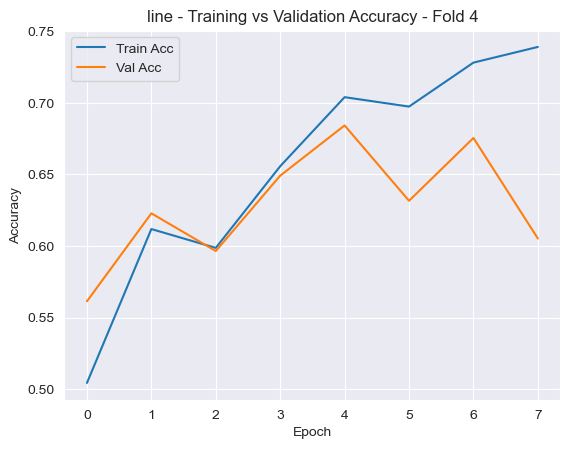

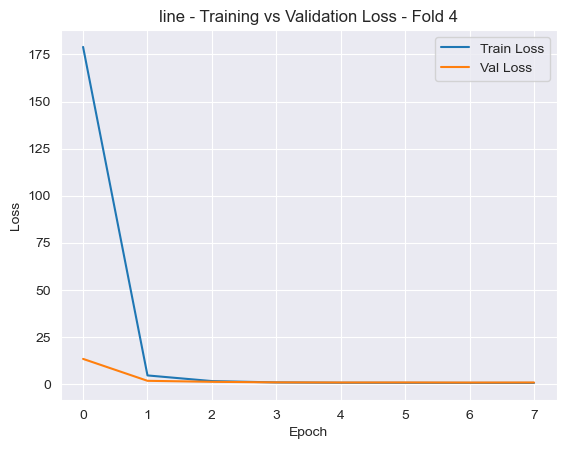

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


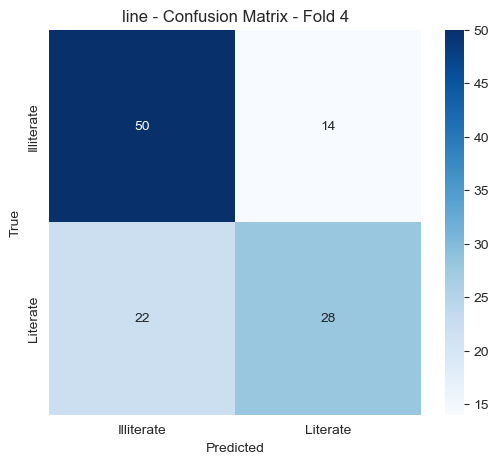

Fold 4 Final Train Acc: 0.7390, Final Val Acc: 0.6053
Found 570 files belonging to 2 classes.
Using 456 files for training.
Found 570 files belonging to 2 classes.
Using 114 files for validation.
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 533ms/step - accuracy: 0.4915 - loss: 386.0968 - val_accuracy: 0.4386 - val_loss: 0.6935
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 445ms/step - accuracy: 0.4561 - loss: 1.5462 - val_accuracy: 0.4386 - val_loss: 0.6935
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 468ms/step - accuracy: 0.4508 - loss: 0.6934 - val_accuracy: 0.4386 - val_loss: 0.6933
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 417ms/step - accuracy: 0.4765 - loss: 0.6932 - val_accuracy: 0.5614 - val_loss: 0.6930
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 429ms/step - accuracy: 0.5452 - loss: 0.6930 - val_accuracy: 0.5614 - val_loss: 0.6927
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 461ms/step - accuracy: 0.5825 - loss: 0.6925 - val_accuracy: 0.5614 - val_loss: 0.6924
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━

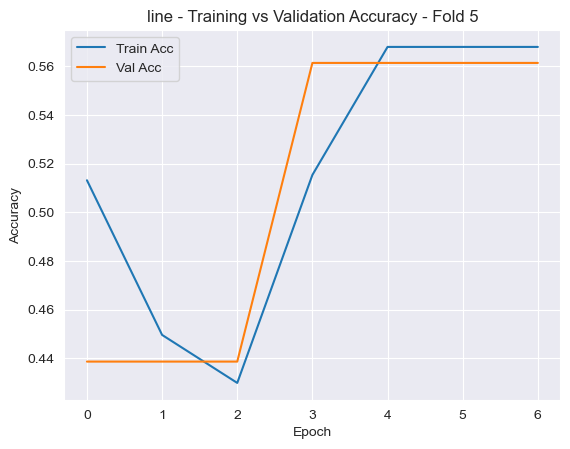

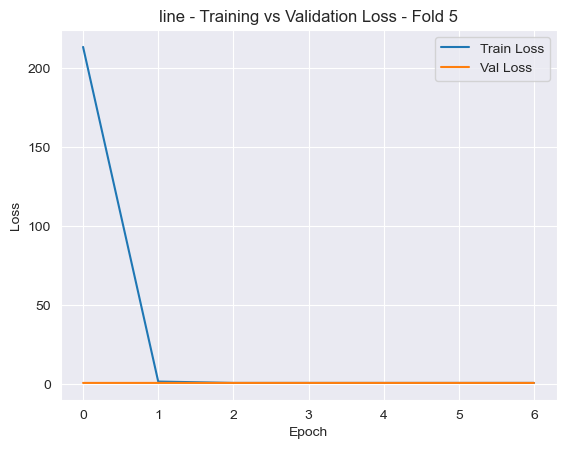

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


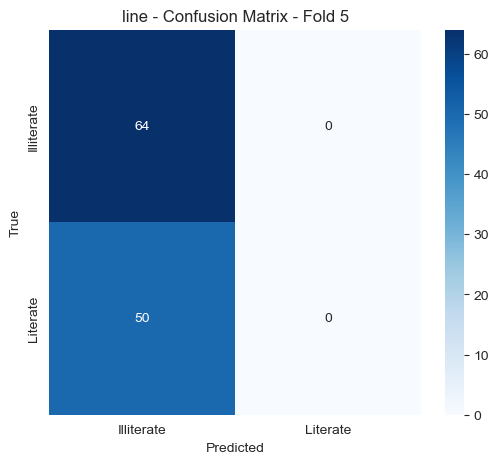

Fold 5 Final Train Acc: 0.5680, Final Val Acc: 0.5614

=== Running 5-fold CV for: pie ===
Found 150 files belonging to 2 classes.
Using 120 files for training.
Found 150 files belonging to 2 classes.
Using 30 files for validation.
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 716ms/step - accuracy: 0.5477 - loss: 499.9609 - val_accuracy: 0.4000 - val_loss: 257.6439
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 512ms/step - accuracy: 0.5923 - loss: 179.8417 - val_accuracy: 0.4000 - val_loss: 193.0107
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 453ms/step - accuracy: 0.6517 - loss: 88.0512 - val_accuracy: 0.4000 - val_loss: 61.6690
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 410ms/step - accuracy: 0.6235 - loss: 24.7286 - val_accuracy: 0.6000 - val_loss: 11.7629
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 467ms/step - accuracy: 0.3777 - loss: 12.7777 - val_accuracy: 0.4000 - val_loss: 3.0071
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 403ms/step - accuracy: 0.6037 - loss: 3.0060 - val_accuracy: 0.4000 - val_loss: 2.0914


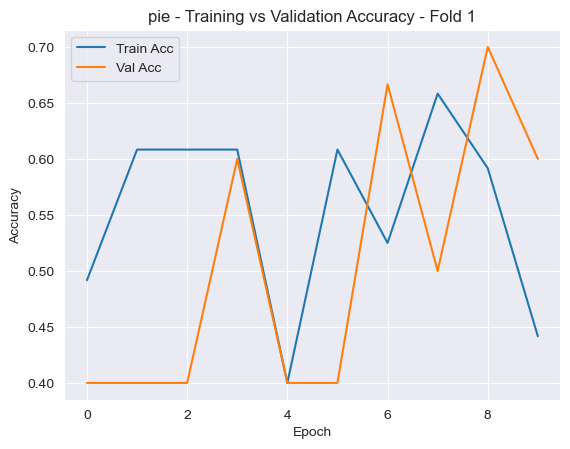

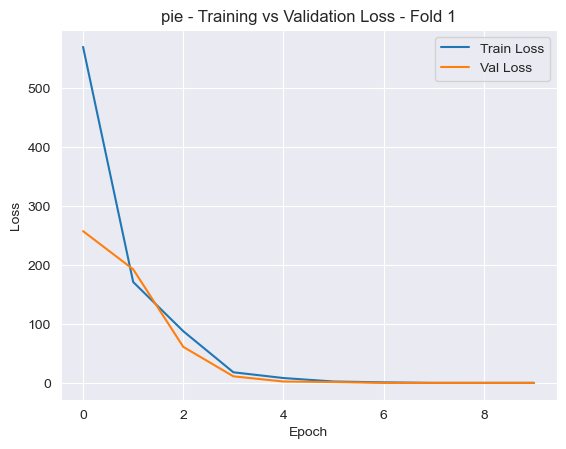

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


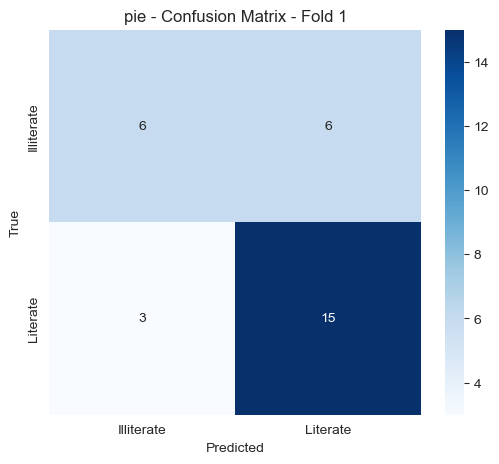

Fold 1 Final Train Acc: 0.4417, Final Val Acc: 0.6000
Found 150 files belonging to 2 classes.
Using 120 files for training.
Found 150 files belonging to 2 classes.
Using 30 files for validation.
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 651ms/step - accuracy: 0.4590 - loss: 913.3705 - val_accuracy: 0.4000 - val_loss: 197.3686
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 465ms/step - accuracy: 0.4669 - loss: 148.1075 - val_accuracy: 0.7333 - val_loss: 17.0331
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 467ms/step - accuracy: 0.5863 - loss: 45.5610 - val_accuracy: 0.4000 - val_loss: 88.6010
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 421ms/step - accuracy: 0.6619 - loss: 33.2505 - val_accuracy: 0.6667 - val_loss: 13.9993
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 423ms/step - accuracy: 0.6779 - loss: 16.0286 - val_accuracy: 0.6667 - val_loss: 6.4278


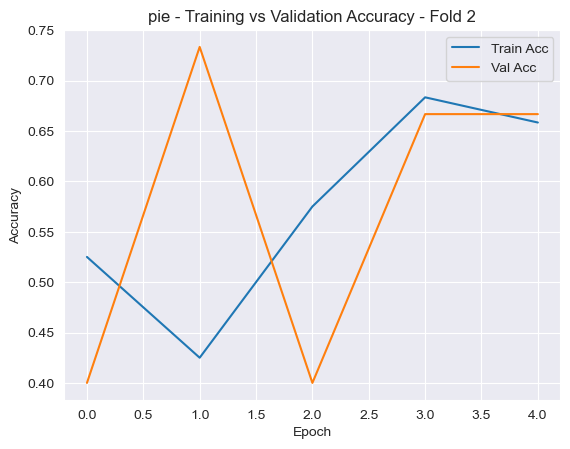

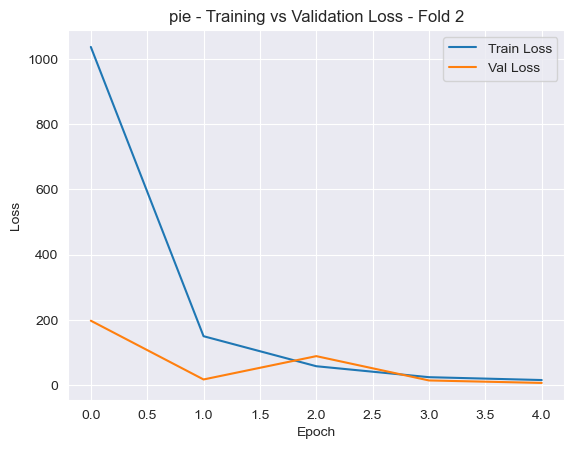

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


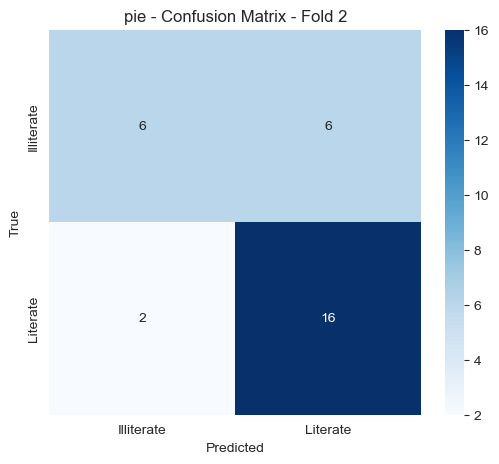

Fold 2 Final Train Acc: 0.6583, Final Val Acc: 0.6667
Found 150 files belonging to 2 classes.
Using 120 files for training.
Found 150 files belonging to 2 classes.
Using 30 files for validation.
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 665ms/step - accuracy: 0.4590 - loss: 356.4276 - val_accuracy: 0.5333 - val_loss: 29.3166
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 422ms/step - accuracy: 0.5165 - loss: 32.6424 - val_accuracy: 0.4000 - val_loss: 26.5999
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 461ms/step - accuracy: 0.6483 - loss: 10.2440 - val_accuracy: 0.6333 - val_loss: 4.5620
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 423ms/step - accuracy: 0.5723 - loss: 5.5463 - val_accuracy: 0.5333 - val_loss: 2.0547
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 454ms/step - accuracy: 0.7873 - loss: 1.2119 - val_accuracy: 0.6000 - val_loss: 1.0113
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 465ms/step - accuracy: 0.6944 - loss: 0.6830 - val_accuracy: 0.6667 - val_loss: 0.6304
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 465m

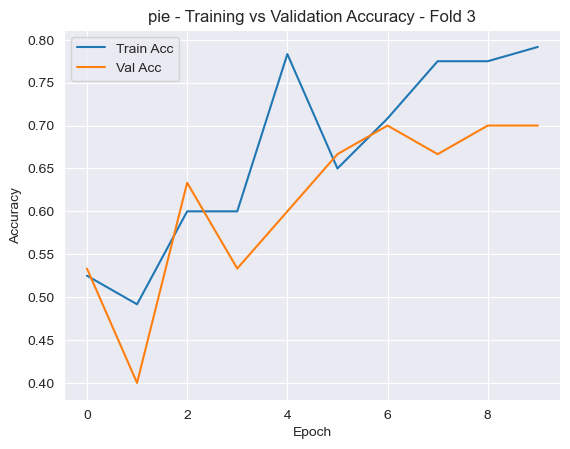

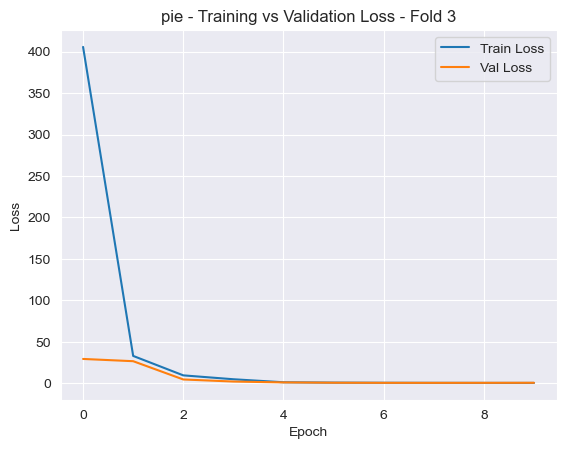

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


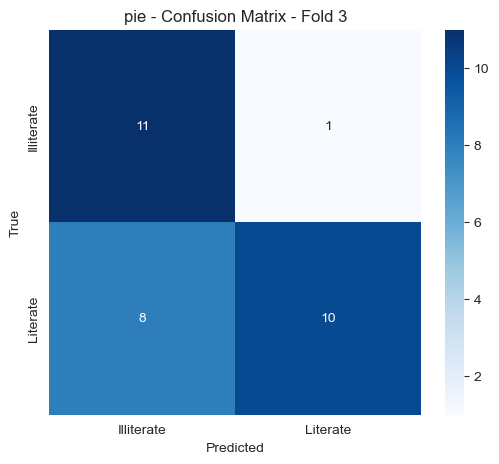

Fold 3 Final Train Acc: 0.7917, Final Val Acc: 0.7000
Found 150 files belonging to 2 classes.
Using 120 files for training.
Found 150 files belonging to 2 classes.
Using 30 files for validation.
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 620ms/step - accuracy: 0.4967 - loss: 308.1394 - val_accuracy: 0.4000 - val_loss: 312.7342
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 434ms/step - accuracy: 0.5890 - loss: 165.8448 - val_accuracy: 0.5333 - val_loss: 34.0020
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 392ms/step - accuracy: 0.7010 - loss: 19.4153 - val_accuracy: 0.6000 - val_loss: 15.5213
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 402ms/step - accuracy: 0.7665 - loss: 6.3080 - val_accuracy: 0.6667 - val_loss: 7.3397
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 462ms/step - accuracy: 0.8263 - loss: 2.5120 - val_accuracy: 0.7000 - val_loss: 3.0715
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 404ms/step - accuracy: 0.8385 - loss: 0.8312 - val_accuracy: 0.7000 - val_loss: 1.5279
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 4

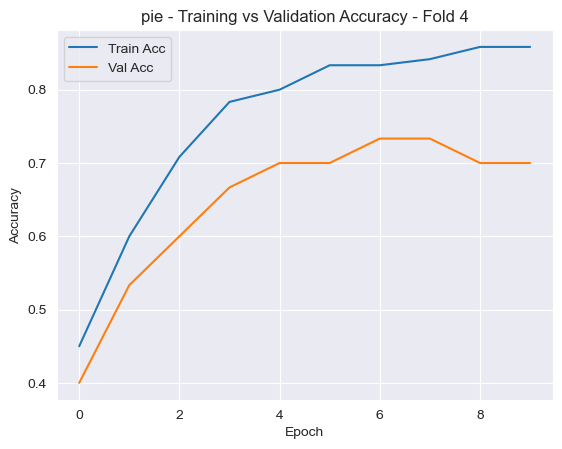

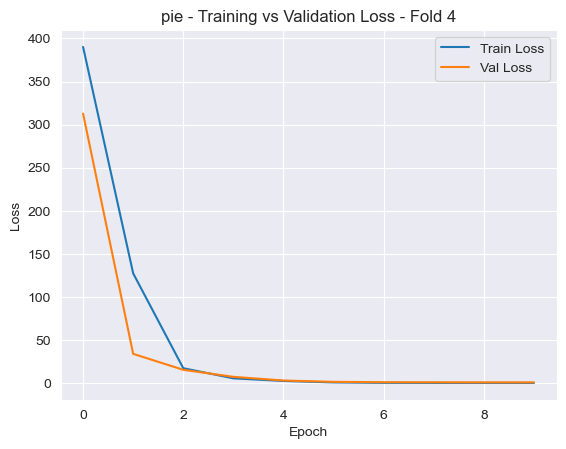

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


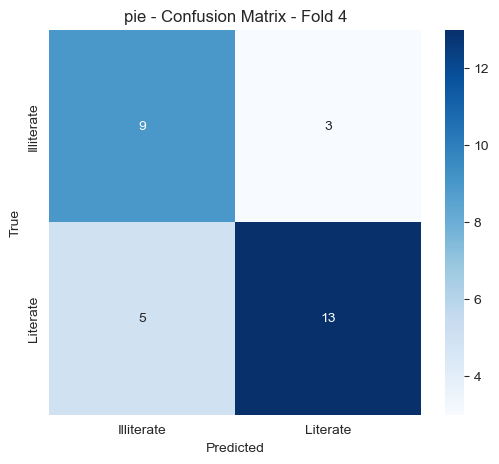

Fold 4 Final Train Acc: 0.8583, Final Val Acc: 0.7000
Found 150 files belonging to 2 classes.
Using 120 files for training.
Found 150 files belonging to 2 classes.
Using 30 files for validation.
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 643ms/step - accuracy: 0.5329 - loss: 1111.8584 - val_accuracy: 0.4000 - val_loss: 54.0101
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 460ms/step - accuracy: 0.4669 - loss: 15.3606 - val_accuracy: 0.6000 - val_loss: 0.6930
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 426ms/step - accuracy: 0.3483 - loss: 0.6934 - val_accuracy: 0.6000 - val_loss: 0.6930
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 447ms/step - accuracy: 0.3819 - loss: 2.3708 - val_accuracy: 0.6000 - val_loss: 0.6930
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 420ms/step - accuracy: 0.3827 - loss: 0.6933 - val_accuracy: 0.6000 - val_loss: 0.6930


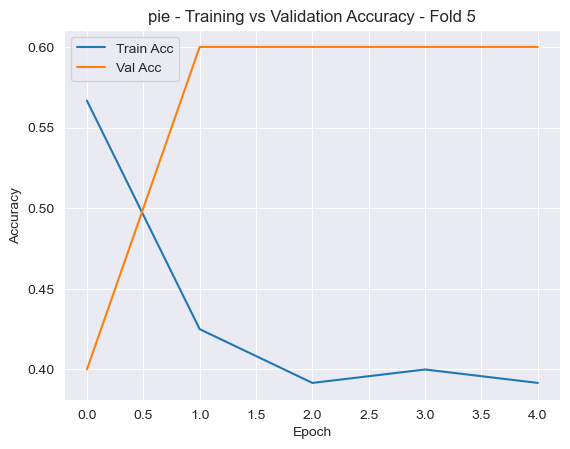

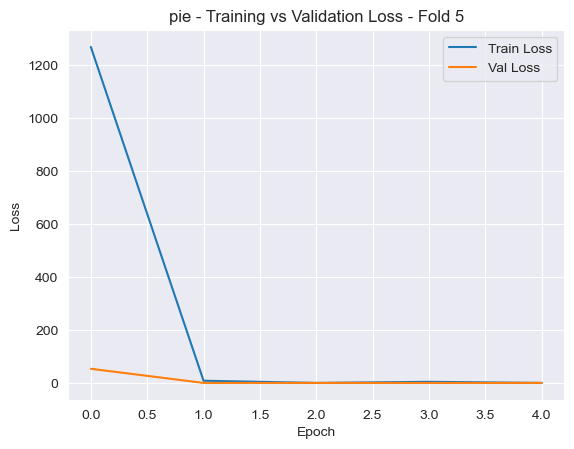

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step


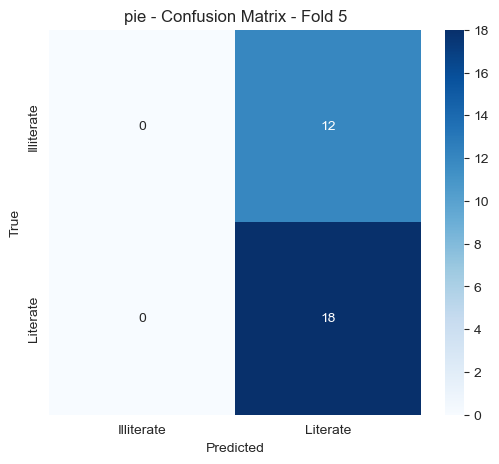

Fold 5 Final Train Acc: 0.3917, Final Val Acc: 0.6000


In [7]:
# Dictionary to hold results per graph type
all_results = {}

# Train and collect results
for dataset_name in ["bar", "line", "pie"]:
    print(f"\n=== Running 5-fold CV for: {dataset_name} ===")
    average_results = {
        "train_accuracies": [],
        "val_accuracies": []
    }

    for fold in range(5):
        train_and_evaluate(dataset_name, fold, average_results)

    # Store the mean results for this dataset
    all_results[dataset_name] = {
        "mean_train": np.mean(average_results["train_accuracies"]),
        "mean_val": np.mean(average_results["val_accuracies"])
    }

In [8]:
# After training all datasets, print summary
print("\n=== Summary of Average Accuracies by Graph Type ===")
for dataset_name, result in all_results.items():
    print(f"\nGraph Type: {dataset_name}")
    print(f"→ Average Train Accuracy: {result['mean_train']:.4f}")
    print(f"→ Average Validation Accuracy: {result['mean_val']:.4f}")


=== Summary of Average Accuracies by Graph Type ===

Graph Type: bar
→ Average Train Accuracy: 0.6494
→ Average Validation Accuracy: 0.5832

Graph Type: line
→ Average Train Accuracy: 0.6746
→ Average Validation Accuracy: 0.5982

Graph Type: pie
→ Average Train Accuracy: 0.6283
→ Average Validation Accuracy: 0.6533
